# OFCOM Survey Data Analysis & Visualisation

## 1. Importing necessary Libraries & Modules

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import datetime as dt
import squarify
import geopandas as gpd
from wordcloud import WordCloud
from matplotlib import cm
from scipy.interpolate import make_interp_spline

## 2. Loading the OFCOM survey data, Regional COVID Cases, Mortality Data and Vaccination Data and UK cases/mortality data 
### Loading the OFCOM data:

In [2]:
path_for_datasets = r'../../6_cleaned_files/ofcom_survey_data'

directory_path = Path(path_for_datasets)

file_list = [f.name for f in directory_path.iterdir() if f.is_file()]

file_paths = [f'{path_for_datasets}/{file}' for file in file_list if file[-4:] == '.csv']

ofcom_dataframes = {}

for i, file_path in enumerate(file_paths):
    
    dataframe = pd.read_csv(file_path)
    
    dataframe['start_date'] = pd.to_datetime(dataframe['start_date'], errors='coerce')
    dataframe['end_date'] = pd.to_datetime(dataframe['end_date'], errors='coerce')
    
    dataframe['start_date'] = dataframe['start_date'].dt.date
    dataframe['end_date'] = dataframe['end_date'].dt.date
    
    ofcom_dataframes[file_list[i][:-12]] = dataframe

In [3]:
dataframe['start_date'] = pd.to_datetime(dataframe['start_date'], errors='coerce')
dataframe['end_date'] = pd.to_datetime(dataframe['end_date'], errors='coerce')

dataframe['start_date'] = dataframe['start_date'].dt.date
dataframe['end_date'] = dataframe['end_date'].dt.date

### Loading the UKHSA regional information for mortality, vaccination and cases

In [4]:
ukhsa_mortality_dataframe = pd.read_csv(r'../../6_cleaned_files/ukhsa_mortality_data/uk_regional_covid_mortality_cleaned.csv')

In [5]:
ukhsa_cases_dataframe = pd.read_csv(r'../../6_cleaned_files/ukhsa_cases_data/ukhsa_cases_data_cleaned.csv')

In [6]:
ukhsa_vaccination_dataframe = pd.read_csv(r'../../6_cleaned_files/ukhsa_vaccination_data/ukhsa_vaccination_data_cleaned.csv')

In [7]:
ukhsa_cases_data_by_date = ukhsa_cases_dataframe.copy()

In [8]:
ukhsa_cases_data_by_date= ukhsa_cases_data_by_date.groupby('date')['new_cases_by_specimen_date'].sum()

### Loading the UK COVID API data 

In [9]:
covid_api_uk_dataframe = pd.read_csv(r'../../6_cleaned_files/covid_api_data/covid_api_uk_cleaned.csv')

# 3. Frequency of getting information and news on the pandemic
## I first get the corresponding dataframe

In [10]:
dataframe = ofcom_dataframes['frequency_of_getting_infonews_about_coronavirus_outbreak_in_last_week']

## I ensure that the dates are appropriately formatted

In [11]:
dataframe['start_date'] = pd.to_datetime(dataframe['start_date'], errors='coerce')
dataframe['end_date'] = pd.to_datetime(dataframe['end_date'], errors='coerce')

dataframe['start_date'] = dataframe['start_date'].dt.date
dataframe['end_date'] = dataframe['end_date'].dt.date

## I want to plot the percentage of respondants over time so I need to create a dataframe which contains unique dates and weighted bases from the dataframe and calculate the percentage of respondents

In [12]:
weighted_bases = dataframe[dataframe['response'] == 'Weighted base'][['start_date', 'total']].reset_index(drop=True)

In [13]:
def get_total(start_date):
    lookup_dict = weighted_bases.set_index('start_date')['total'].to_dict()
    
    return lookup_dict.get(start_date)

dataframe['weighted_base'] = dataframe['start_date'].map(get_total)

In [14]:
dataframe['percentage_total_respondents'] = round((dataframe['total']/dataframe['weighted_base']) * 100, 2)

In [15]:
dataframe = dataframe[['start_date', 'response', 'percentage_total_respondents']]

In [16]:
dataframe = dataframe[~dataframe['response'].isin(['Unweighted base', 'NET: At least once a day', 'Weighted base'])]

## I then get the comparative data from the COVID-19 API to plot on the graph

In [17]:
start_date = min(dataframe['start_date'])

In [18]:
end_date = max(dataframe['start_date'])

In [19]:
cases_dataframe = covid_api_uk_dataframe.copy()

In [20]:
cases_dataframe['date'] = pd.to_datetime(cases_dataframe['date'], errors='coerce')
cases_dataframe['date'] = cases_dataframe['date'].dt.date

In [21]:
date_filtered_dataframe = cases_dataframe[(cases_dataframe['date'] >= start_date) & (cases_dataframe['date'] <= end_date)]

In [22]:
cases_dataframe = date_filtered_dataframe[['date','confirmed_diff']]

In [23]:
mortality_dataframe = date_filtered_dataframe[['date','deaths']]

In [24]:
df_no_outliers = cases_dataframe.copy()

### Finally, I plot the graph:

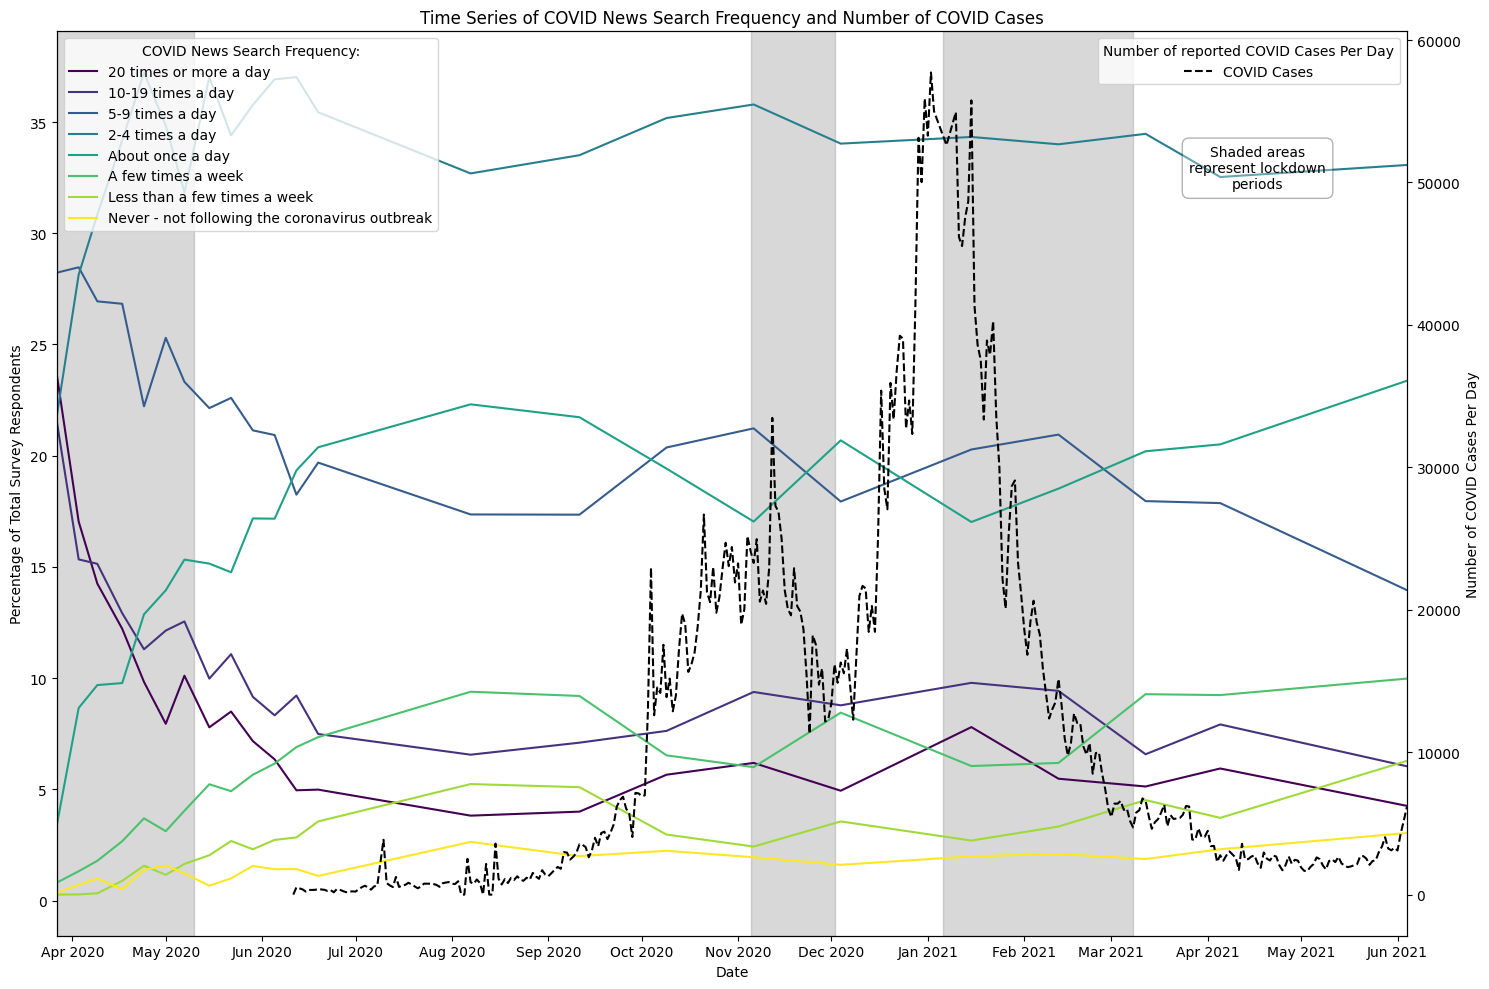

In [25]:
fig, ax1 = plt.subplots(figsize=(15, 10))

colours = plt.cm.viridis(np.linspace(0, 1, len(dataframe['response'].unique())))

for i, category in enumerate(dataframe['response'].unique()):
    category_data = dataframe[dataframe['response'] == category]
    ax1.plot(category_data['start_date'], category_data['percentage_total_respondents'], 
             label=category, linestyle='-', color=colours[i])

ax1.set_xlabel('Date')
ax1.set_ylabel('Percentage of Total Survey Respondents')

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

ax1.set_xlim([dt.datetime(2020, 3, 27), dt.datetime(2021, 6, 4)])

ax2 = ax1.twinx()

ax2.plot(cases_dataframe['date'], cases_dataframe['confirmed_diff'], label='COVID Cases', linestyle='--', color='black')
ax2.set_ylabel('Number of COVID Cases Per Day')

ax1.legend(title='COVID News Search Frequency:', loc='upper left')
ax2.legend(title='Number of reported COVID Cases Per Day', loc='upper right')

ax1.grid(False)
ax2.grid(False)

for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    
ax1.set_facecolor('white')
ax2.set_facecolor('white')

lockdown_periods = [
    ('2020-03-27', '2020-05-10', '1st Lockdown'),
    ('2020-11-05', '2020-12-02', '2nd Lockdown'),
    ('2021-01-06', '2021-03-08', '3rd Lockdown'),
]
    
for start_date, end_date, label in lockdown_periods:
    ax1.axvspan(
        dt.datetime.strptime(start_date, '%Y-%m-%d'), 
        dt.datetime.strptime(end_date, '%Y-%m-%d'), 
        color='gray', alpha=0.3, label=label
    )

plt.text(
    dt.datetime(2021, 4, 17), 51000,
    'Shaded areas\nrepresent lockdown\nperiods',
    fontsize=10,
    color='black',
    ha='center',
    va='center',
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        boxstyle='round,pad=0.5', 
        alpha=0.3
    )
)

plt.title('Time Series of COVID News Search Frequency and Number of COVID Cases')

plt.tight_layout()

plt.savefig('../../8_final_visualisations/misinformation_ofcom/frequency_of_sourcing_news/misinformation_frequency_of_news_covid_timeseries.png', dpi=300)

plt.show()

In [26]:
## Streamgraph

In [27]:
streamplot_dataframe = dataframe.copy()

In [28]:
streamplot_dataframe = streamplot_dataframe.drop_duplicates()

In [29]:
streamplot_dataframe

,start_date,response,percentage_total_respondents
2,2020-03-27,20 times or more a day,23.61
3,2020-03-27,10-19 times a day,21.51
4,2020-03-27,5-9 times a day,28.23
5,2020-03-27,2-4 times a day,21.82
6,2020-03-27,About once a day,3.41
...,...,...,...
271,2021-06-04,2-4 times a day,33.07
272,2021-06-04,About once a day,23.37
273,2021-06-04,A few times a week,9.98
274,2021-06-04,20 times or more a day,4.26


In [30]:
reshaped_df = streamplot_dataframe.pivot(
    index='start_date',
    columns='response',
    values='percentage_total_respondents'
)

In [31]:
reshaped_df = reshaped_df.reset_index()

In [32]:
reshaped_df['start_date'] = pd.to_datetime(reshaped_df['start_date'])

In [33]:
reshaped_df['start_date'] = reshaped_df['start_date'].map(pd.Timestamp.toordinal)

In [34]:
reshaped_df = reshaped_df.set_index('start_date')

In [35]:
reshaped_df = reshaped_df[['Never - not following the coronavirus outbreak', 'Less than a few times a week', 'A few times a week', 'About once a day', '2-4 times a day', '5-9 times a day', '10-19 times a day', '20 times or more a day']]

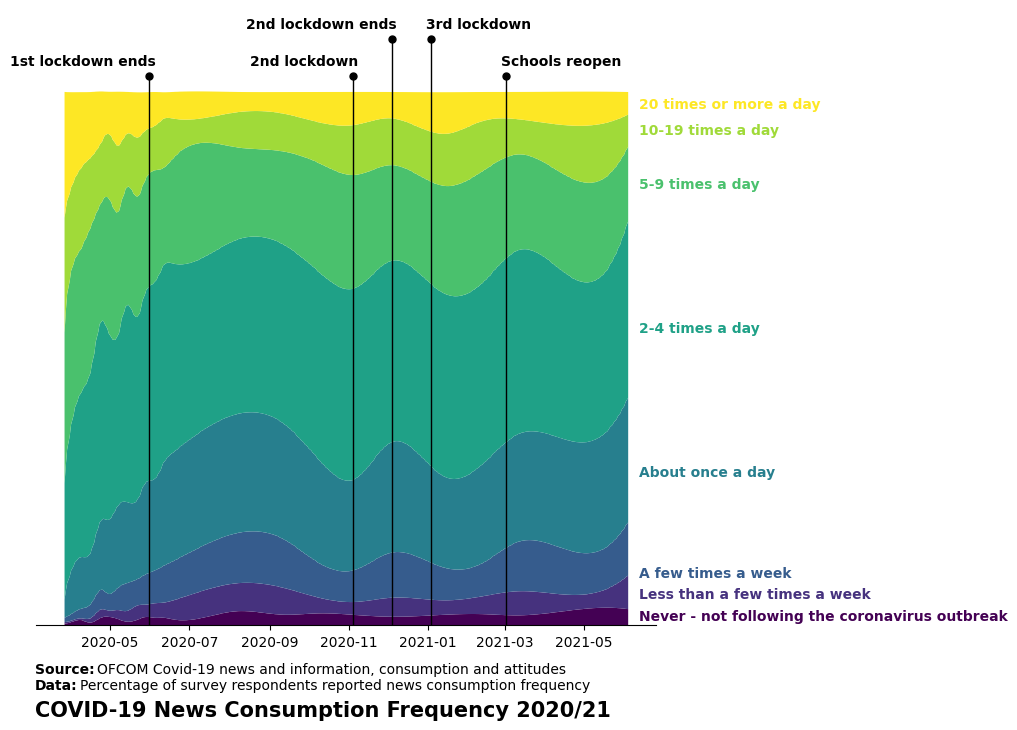

In [36]:
custom_colors = cm.viridis(np.linspace(0, 1, len(reshaped_df.columns)))

x_smooth = np.linspace(reshaped_df.index.min(), reshaped_df.index.max(), 300)

pivot_smooth = pd.DataFrame({
    column: make_interp_spline(reshaped_df.index, reshaped_df[column])(x_smooth)
    for column in reshaped_df
})

x_smooth_dates = pd.to_datetime([pd.Timestamp.fromordinal(int(date)) for date in x_smooth])

plt.figure(figsize=(8, 8))
plt.stackplot(
    x_smooth_dates,
    pivot_smooth.values.T,
    labels=reshaped_df.columns,
    colors=custom_colors
)

ax = plt.gca()

# Line to demonstrate the 1st lockdown end
ax.plot([18413, 18413],[0, 103], color='black', linewidth=1)    
ax.plot(18413, 103, marker='o', markersize=5, color='black')
plt.text(18306, 105, '1st lockdown ends', fontsize=10, color='black', fontweight='bold')

# Line to demonstrate the 2nd lockdown start
ax.plot([18570, 18570],[0, 103], color='black', linewidth=1)    
ax.plot(18570, 103, marker='o', markersize=5, color='black')
plt.text(18491, 105, '2nd lockdown', fontsize=10, color='black', fontweight='bold')

# Line to demonstrate the 2nd lockdown end
ax.plot([18600, 18600],[0, 110], color='black', linewidth=1)    
ax.plot(18600, 110, marker='o', markersize=5, color='black')
plt.text(18488, 112, '2nd lockdown ends', fontsize=10, color='black', fontweight='bold')

# Line to demonstrate the 3rd lockdown start
ax.plot([18630, 18630],[0, 110], color='black', linewidth=1)    
ax.plot(18630, 110, marker='o', markersize=5, color='black')
plt.text(18626, 112, '3rd lockdown', fontsize=10, color='black', fontweight='bold')

# Line to demonstrate the school reopening 
ax.plot([18688, 18688],[0, 103], color='black', linewidth=1)    
ax.plot(18688, 103, marker='o', markersize=5, color='black')
plt.text(18684, 105, 'Schools reopen', fontsize=10, color='black', fontweight='bold')

def add_annotations_frequency(news_check_frequency, value_placement, color):
    plt.text(18790, value_placement, news_check_frequency, fontsize=10, color=color, fontweight='bold')

frequencies = ['Never - not following the coronavirus outbreak', 'Less than a few times a week', 'A few times a week', 'About once a day', '2-4 times a day', '5-9 times a day', '10-19 times a day', '20 times or more a day']
values_placement = [1, 5, 9, 28, 55, 82, 92, 97]
custom_colors.tolist().reverse()

for frequency, value, colour in zip(frequencies, values_placement, custom_colors):
    add_annotations_frequency(frequency, value, colour)

plt.text(18325, -17,
         'COVID-19 News Consumption Frequency 2020/21',
         fontsize=15, 
         color='black',
         fontweight = 'bold')

plt.text(18325, -9, 'Source:', fontsize=10, color='black', fontweight = 'bold')
plt.text(18373, -9, 'OFCOM Covid-19 news and information, consumption and attitudes', fontsize=10, color='black')
plt.text(18325, -12, 'Data:', fontsize=10, color='black', fontweight = 'bold')
plt.text(18360, -12, 'Percentage of survey respondents reported news consumption frequency', fontsize=10, color='black')

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(left=False, labelleft=False)

plt.savefig('../../8_final_visualisations/misinformation_ofcom/frequency_of_sourcing_news/stacked_area_chart_frequency.png', bbox_inches='tight', 
            dpi=300)

plt.show()

# 4. Sources used to get information about the coronavirus outbreak

In [37]:
sources_used_dataframe = ofcom_dataframes['sources_used_to_get_infonews_about_coronavirus_outbreak_in_last_week']

### As I will be plotting many time series for the graph, I made a function to return the weighted percentages:

In [38]:
def calculate_percentage(dataframe):
    
    weighted_bases = dataframe[dataframe['response'] == 'Weighted base'][['start_date', 'total']].reset_index(drop=True)

    def get_total(start_date):
        lookup_dict = weighted_bases.set_index('start_date')['total'].to_dict()
        return lookup_dict.get(start_date)

    dataframe['weighted_base'] = dataframe['start_date'].map(get_total)

    dataframe['percentage_total_respondents'] = round((dataframe['total'] / dataframe['weighted_base']) * 100, 2)

    return dataframe[['start_date', 'response', 'percentage_total_respondents']]

In [39]:
sources_used_dataframe = calculate_percentage(sources_used_dataframe)

In [40]:
# sources_used_dataframe

In [41]:
sources_used_dataframe = sources_used_dataframe[~sources_used_dataframe['response'].isin(['Unweighted base', 'NET: At least once a day', 'Weighted base'])]

### From the response categories (uncomment) I have selected a few broad categories of interest for different plots

In [42]:
# sources_used_dataframe['response'].unique()

In [43]:
local_news = [
    "Family and friends directly",
    "Community radio",
    "People in your local area/neighbourhood"
]

In [44]:
newspapers = [
        '“Red-top tabloids” such as The Sun or Daily Mirror ( printed )',
       '“Red-top tabloids” such as The Sun or Mirror ( online )',
       '“Broadsheets” such as The Times or Guardian',
       '“Broadsheets” such as The Times or Guardian ( online )',
       '“Mid-market tabloids” such as The Daily Mail or Daily Express ( printed )',
       '“Mid-market tabloids” such as MailOnline or Express ( online )'
]

#### After playing with the plotting function, I noted that the response changed from Direct from Government website/ email/ text/ post to Direct from UK Government website/ email/ text/ post I therefore combined the groups

In [45]:
official_sources = [
    "Direct from Local health service website/ email/ text/ post",
    "Direct from NHS website/ email/ text/ post",
    "Direct from World Health Organisation (WHO) website/ email/ text/ post",
    "Direct from UK Government website/ email/ text/ post",
    "Direct from Local council website/ email/ text/ post",
    "Official scientists"
]

In [46]:
sources_used_dataframe.loc[sources_used_dataframe['response'] == "Direct from Government website/ email/ text/ post", 'response'] = "Direct from UK Government website/ email/ text/ post"

In [47]:
television = [
    'BBC - TV',
    'Channel 4',
    'Channel 5',
    'ITV'
]

In [48]:
social_media = [
    "NET: Social Media",
    "NET: Facebook (Facebook and Facebook Messenger)",
    "NET: WhatsApp (WhatsApp and WhatsApp groups)",
    "Instagram",
    "Twitter",
    "YouTube",
    "Snapchat",
]

## I created a function to plot similar Time Series graphs to Save time and decide which Plots are most relevant

In [49]:
def plot_time_series(dataframe_1, dataframe_2, categories, filename, plot_title, x_title, y_title, y2_title, legend_1_title, legend_2_title, min_date, max_date):
    fig, ax1 = plt.subplots(figsize=(15, 10))

    colours = plt.cm.viridis_r(np.linspace(0, 1, len(dataframe['response'].unique())))

    for i, category in enumerate(categories):
        category_data = dataframe_1[dataframe_1['response'] == category]
        ax1.plot(category_data['start_date'], category_data['percentage_total_respondents'], 
                 label=category, linestyle='-', color = colours[i])
    ax1.grid(False)

    for spine in ax1.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        
    ax1.set_facecolor('white')

    ax1.set_xlabel(f'{x_title}')
    ax1.set_ylabel(f'{y_title}')

    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    ax2 = ax1.twinx()

    ax2.grid(False)
    
    ax2.set_facecolor('white')

    ax2.plot(dataframe_2['date'], dataframe_2['confirmed_diff'], label=f'{y2_title}', linestyle='--', color='black')
    ax2.set_ylabel('Number of COVID Cases Per Day')

    ax1.legend(title=f'{legend_1_title}', loc='upper left')
    ax2.legend(title=f'{legend_2_title}', loc='upper right')

    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.set_xlim([min_date, max_date])
    
    lockdown_periods = [
        ('2020-03-27', '2020-05-10', '1st Lockdown'),
        ('2020-11-05', '2020-12-02', '2nd Lockdown'),
        ('2021-01-06', '2021-03-08', '3rd Lockdown'),
    ]

    for start_date, end_date, label in lockdown_periods:
        ax1.axvspan(
            dt.datetime.strptime(start_date, '%Y-%m-%d'), 
            dt.datetime.strptime(end_date, '%Y-%m-%d'), 
            color='gray', alpha=0.3, label=label
        )

    plt.text(
    dt.datetime (2021, 4, 17), 51000,
    'Shaded areas\nrepresent lockdown\nperiods',
    fontsize=10,
    color='black',
    ha='center',
    va='center',
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        boxstyle='round,pad=0.5', 
        alpha=0.3
    )
)

    plt.title(f'{plot_title}')
    plt.tight_layout()

    plt.savefig(f'{filename}.png', dpi=300)

    plt.close('all')

#### I set the root for the file path for the news_source_figures

In [50]:
root_image_path = r'../../8_final_visualisations/misinformation_ofcom/news_sources_figures/'

## I also create two functions to filter the dataframe and return minimum and maximum date

In [51]:
def filter_dataframe(dataframe, category):
    copy_dataframe = dataframe.copy()
    copy_dataframe = copy_dataframe[copy_dataframe['response'].isin(category)]
    return copy_dataframe

In [52]:
def return_min_max_date(dataframe):
    min_date = dataframe['start_date'].min()
    max_date = dataframe['start_date'].max()
    return min_date, max_date

## Plotting the newspaper sources dataframe

In [53]:
newspaper_dataframe = filter_dataframe(sources_used_dataframe, newspapers)

In [54]:
min_date, max_date = return_min_max_date(newspaper_dataframe)

In [55]:
plot_time_series(dataframe_1 = newspaper_dataframe, dataframe_2 = df_no_outliers, categories = newspapers, plot_title = 'Time Series of Newspaper Source Usage and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents using Newspaper Source', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}newspaper_sources_time_series', min_date = min_date, max_date = max_date)

## Plotting the official sources data

In [56]:
official_sources_dataframe = filter_dataframe(sources_used_dataframe, official_sources)

In [57]:
min_date, max_date = return_min_max_date(official_sources_dataframe)

In [58]:
plot_time_series(dataframe_1 = official_sources_dataframe, dataframe_2 = df_no_outliers, categories = official_sources, plot_title = 'Time Series of Official Source Usage and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents using Official Source', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}official_sources_time_series', min_date = min_date, max_date = max_date)

## Plotting the television sources data

In [59]:
television_sources_dataframe = filter_dataframe(sources_used_dataframe, television)

In [60]:
min_date, max_date = return_min_max_date(television_sources_dataframe)

In [61]:
plot_time_series(dataframe_1 = television_sources_dataframe, dataframe_2 = df_no_outliers, categories = television, plot_title = 'Time Series of Television News Source Usage and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents using Television News Source', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}television_time_series', min_date = min_date, max_date = max_date)

## Plotting the social media source usage

In [62]:
social_media_dataframe = filter_dataframe(sources_used_dataframe, social_media)

In [63]:
min_date, max_date = return_min_max_date(social_media_dataframe)

In [64]:
plot_time_series(dataframe_1 = social_media_dataframe, dataframe_2 = df_no_outliers, categories = social_media, plot_title = 'Time Series of Social Media News Source Usage and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents using Social Media News Source', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}social_media_time_series', min_date = min_date, max_date = max_date)

## Plotting the local news source usage


In [65]:
local_news_dataframe = filter_dataframe(sources_used_dataframe, local_news)

In [66]:
min_date, max_date = return_min_max_date(local_news_dataframe)

In [67]:
plot_time_series(dataframe_1 = local_news_dataframe, dataframe_2 = df_no_outliers, categories = local_news, plot_title = 'Time Series of Local News Source Usage and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents (%)', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents using Local News Source', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}local_news_time_series', min_date = min_date, max_date = max_date)

In [68]:
## I created a pie chart plotting function which can be called in a similar manner to save time when plotting these graphs and to add consistency to the layout

In [69]:
def plot_pie_chart(data, labels, output_file, title, colorscheme='viridis', explode_index=0, figsize=(16, 12)):

    plt.figure(figsize=figsize)

    colors = plt.colormaps.get_cmap(colorscheme)(np.linspace(0, 0.95, len(labels)))

    viridis_colors = plt.cm.viridis(np.linspace(0, 0.95, 16))


    explosion = np.zeros(len(data))
    explosion[explode_index] = 0.1

    _, _, autotexts = plt.pie(
        data,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        startangle=140,
        labeldistance=1.1,
        explode=explosion

    )

    for autotext in autotexts:
        autotext.set_color('white')

    plt.title(title, fontsize=14)

    plt.tight_layout()

    plt.savefig(output_file, dpi=300)

    plt.close('all')

# 5. Most important news source

In [70]:
most_important_source_dataframe = ofcom_dataframes['most_important_source_used_in_last_week']

## Pie chart of all source frequencies

## I plotted the pie chart for the sources described as most important, I ran into some challenges when plotting as there were so many graphs I therefore played around with groupings to find the combination which allowed me to see meaningful data without combining too many of the smaller columns:

In [71]:
source_frequency = most_important_source_dataframe.copy()

In [72]:
source_frequency = source_frequency[['response', 'total']]

In [73]:
source_frequency = source_frequency.groupby('response').sum()

In [74]:
source_frequency = source_frequency[~source_frequency.index.str.contains('NET:|Weighted base|Unweighted base')]

In [75]:
source_frequency = source_frequency.sort_values(by='total', ascending = False)

In [76]:
biggest_news_sources = source_frequency[:15]

In [77]:
other = source_frequency[15:]
other_total = other.sum().item()   

In [78]:
current_other_row = biggest_news_sources.loc['Other']

In [79]:
current_other_row_total = current_other_row.iloc[0].item()

In [80]:
current_other_row['total'] = other_total + current_other_row_total

In [81]:
biggest_news_sources = biggest_news_sources.sort_values(by='total', ascending = False)

In [82]:
data = biggest_news_sources['total']

In [83]:
output_filepath = rf'../../8_final_visualisations/misinformation_ofcom/news_sources_figures/all_sources_piechart.png'

In [84]:
title = "Percieved Most Important News Sources During the Pandemic (All Sources)"

In [85]:
explosion = np.zeros(len(biggest_news_sources['total']))
explosion[0] = 0.1

In [86]:
plot_pie_chart(
    data=data, 
    labels = biggest_news_sources.index, 
    output_file = output_filepath, 
    title = title, 
    colorscheme='viridis', 
    explode_index=0, 
    figsize=(16, 12))

## Trial plotting with enhanced graphical appearence 

In [87]:
biggest_news_sources.index

Index(['BBC - TV', 'Other', 'BBC - Online/ app', 'Sky', 'ITV', 'BBC - Radio',
       'Direct from NHS website/ email/ text/ post',
       'Websites or apps that bring together news from different news providers',
       'Direct from UK Government website/ email/ text/ post',
       '“Broadsheets” such as The Times or Guardian ( online )', 'Facebook',
       'Search engine (e.g. Google)', 'Family and friends directly', 'Twitter',
       'Direct from Government website/ email/ text/ post'],
      dtype='object', name='response')

In [88]:
biggest_news_sources.rename(index={"Direct from NHS website/ email/ text/ post": "NHS website/ email/ text/ post",
                                   "Websites or apps that bring together news from different news providers": "Aggregated news platforms",
                                   "Direct from UK Government website/ email/ text/ post": "UK Government website/ email/ text/ post",
                                   '“Broadsheets” such as The Times or Guardian ( online )': '“Broadsheets” ( online )',
                                    "Search engine (e.g. Google)": "Search engines",
                                   "Direct from Government website/ email/ text/ post": "Government website/ email/ text/ post",
                                  }, inplace=True)


In [89]:
plt.figure(figsize=(16, 12))

colors = plt.colormaps.get_cmap('viridis')(np.linspace(0, 0.95, len(biggest_news_sources)))

viridis_colors = plt.cm.viridis(np.linspace(0, 0.95, 16))

wedges, texts, autotexts = plt.pie(
    data,
    labels=biggest_news_sources.index,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    labeldistance=1.06,
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)  

for text, color in zip(texts, colors):
    text.set_fontweight('bold')
    text.set_fontsize(12)       
    text.set_color(color) 

plt.text(-1.25, -1.3,"Preferred News Sources During COVID-19", fontsize=30, color='black', fontweight = 'bold')

plt.text(-1.25, -1.15, 'Source:', fontsize=12, color='black', fontweight = 'bold')
plt.text(-1.08, -1.15, 'OFCOM Covid-19 news and information, consumption and attitudes.', fontsize=12, color='black')
plt.text(-1.25, -1.20, 'Metric:', fontsize=12, color='black', fontweight = 'bold')
plt.text(-1.09, -1.20, 'Most important news sources.', fontsize=12, color='black')

plt.tight_layout()

plt.savefig(r'../../8_final_visualisations/misinformation_ofcom/news_sources_figures/news_sources_updated_visual', dpi=300)

plt.close('all')

## Pie Chart for grouped source frequencies

In [90]:
net_information_sources_most_important = most_important_source_dataframe.copy()

In [91]:
net_information_sources_most_important = net_information_sources_most_important[['response', 'total']]

In [92]:
net_information_sources_most_important = net_information_sources_most_important.groupby('response').sum()

In [93]:
net_information_sources_most_important = net_information_sources_most_important[net_information_sources_most_important.index.str.contains('NET:')]

In [94]:
net_information_sources_most_important = net_information_sources_most_important.sort_values(by='total', ascending = False)

In [95]:
net_information_sources_most_important = net_information_sources_most_important[~net_information_sources_most_important.index.isin(['NET: Offline', 'NET: Closed groups', 'NET: WhatsApp (WhatsApp and WhatsApp groups)'])]

In [96]:
data = net_information_sources_most_important['total']

In [97]:
output_file = r'../../8_final_visualisations/misinformation_ofcom/news_sources_figures/net_most_important_piechart.png'

In [98]:
title = "Percieved Most Important News Sources During the Pandemic (Grouped Sources)"

In [99]:
plot_pie_chart(
    data=data, 
    labels = net_information_sources_most_important.index, 
    output_file = output_file, 
    title = title, 
    colorscheme='viridis', 
    explode_index=0, 
    figsize=(16, 12))

plt.close('all')

## Time series graphs of change in grouped information sources over time

In [100]:
most_important_source_dataframe = calculate_percentage(most_important_source_dataframe)

In [101]:
most_important_source_dataframe = most_important_source_dataframe[~most_important_source_dataframe['response'].isin(['Unweighted base', 'NET: At least once a day', 'Weighted base'])]

## Local News information sources

In [102]:
local_news_dataframe = filter_dataframe(most_important_source_dataframe, local_news)

In [103]:
min_date, max_date = return_min_max_date(local_news_dataframe)

In [104]:
plot_time_series(dataframe_1 = local_news_dataframe, dataframe_2 = df_no_outliers, categories = local_news, plot_title = 'Time Series of Respondants Considering Each Local News Source as The Most Important and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents (%)', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents considering Local News Source Most Important', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}most_important_local_news_time_series', min_date = min_date, max_date = max_date)

## Newspaper information sources

In [105]:
newspapers_dataframe = filter_dataframe(most_important_source_dataframe, newspapers)

In [106]:
min_date, max_date = return_min_max_date(newspapers_dataframe)

In [107]:
plot_time_series(dataframe_1 = newspapers_dataframe, dataframe_2 = df_no_outliers, categories = newspapers, plot_title = 'Time Series of Respondants Considering Newspaper Source as The Most Important and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents (%)', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents considering Newspaper Source Most Important', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}most_important_newspaper_time_series', min_date = min_date, max_date = max_date)

## Official information sources

In [108]:
official_sources_dataframe = filter_dataframe(most_important_source_dataframe, official_sources)

In [109]:
min_date, max_date = return_min_max_date(official_sources_dataframe)

In [110]:
plot_time_series(dataframe_1 = official_sources_dataframe, dataframe_2 = df_no_outliers, categories = official_sources, plot_title = 'Time Series of Respondants Considering Official Source as The Most Important and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents (%)', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents considering Official Source Most Important', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}most_important_official_source_time_series', min_date = min_date, max_date = max_date)

## Television Information Sources

In [111]:
television_sources_dataframe = filter_dataframe(most_important_source_dataframe, television)

In [112]:
min_date, max_date = return_min_max_date(television_sources_dataframe)

In [113]:
plot_time_series(dataframe_1 = television_sources_dataframe, dataframe_2 = df_no_outliers, categories = television, plot_title = 'Time Series of Respondants Considering Television Source as The Most Important and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents (%)', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents considering Television Source Most Important', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}most_important_official_source_time_series', min_date = min_date, max_date = max_date)

## Social Media

In [114]:
social_media_sources_dataframe = filter_dataframe(most_important_source_dataframe, social_media)

In [115]:
min_date, max_date = return_min_max_date(social_media_sources_dataframe)

In [116]:
plot_time_series(dataframe_1 = social_media_sources_dataframe, dataframe_2 = df_no_outliers, categories = social_media, plot_title = 'Time Series of Respondants Considering Television Source as The Most Important and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents (%)', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents considering Social Media Source Most Important', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}most_important_social_media_source_time_series', min_date = min_date, max_date = max_date)

## 6. Trust in the news

In [117]:
trust_in_source_dataframe = ofcom_dataframes['trust_in_the_sources_for_informationnews_about_coronavirus_used_in_last_week']

In [118]:
trust_in_source_dataframe = calculate_percentage(trust_in_source_dataframe)

In [119]:
trust_in_source_dataframe = trust_in_source_dataframe[~trust_in_source_dataframe['response'].isin(['Unweighted base', 'Weighted base', 'NET: Trust', 'NET: Do not trust', 'Mean', 'Standard deviation Standard error'])]

In [120]:
min_date, max_date = return_min_max_date(trust_in_source_dataframe)

In [121]:
categories = trust_in_source_dataframe['response'].unique()

In [122]:
plot_time_series(dataframe_1 = trust_in_source_dataframe, dataframe_2 = df_no_outliers, categories = categories, plot_title = 'Time Series of Trust in News Sources and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents (%)', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents and their Trust Rating', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}trust_in_news_source_time_series', min_date = min_date, max_date = max_date)

## 7. Frequency of Exposure to misinformation 
### Exposure to misinformation over the pandemic

In [123]:
exposure_fake_news = ofcom_dataframes['whether_came_across_informationnews_about_coronavirus_that_you_think_has_been_false_or_misleading_in_last_week']

In [124]:
exposure_fake_news = calculate_percentage(exposure_fake_news)

In [125]:
exposure_fake_news = exposure_fake_news[~exposure_fake_news['response'].isin(['Unweighted base', 'Weighted base'])]

In [126]:
categories = exposure_fake_news['response'].unique()

In [127]:
min_date, max_date = return_min_max_date(exposure_fake_news)

In [128]:
plot_time_series(dataframe_1 = exposure_fake_news, dataframe_2 = df_no_outliers, categories = categories, plot_title = 'Time Series of Exposure to Misinformation and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents (%)', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents Who Have Been Exposed', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}exposure_to_misinformation_time_series', min_date = min_date, max_date = max_date)

## 8. How misinformation has been reported

### I iterated over several of the OFCOM dataframes to produce stacking bar charts which demonstrated how different sources were reported and how this was percieved by gender, age, region and social class to see if any patterns emerge.

In [129]:
fake_news = [ 'how_claims_that_the_coronavirus_vaccine_is_a_cover_for_a_plan_to_implant_trackable_microchips_in_people_have_been_reported',
    'how_claims_that_the_coronavirus_vaccine_may_reduce_fertility_have_been_reported',
    'how_theory_that_the_origin_or_cause_of_coronavirus_is_in_some_way_linked_to_5g_technology_has_been_reported',
    'how_claims_about_injecting_disinfectant_have_been_reported',
    'how_claims_about_empty_hospitals_on_social_media_posts_prove_that_coronavirus_has_been_exaggerated_have_been_reported','how_claims_about_the_coronavirus_test_which_shows_if_you_currently_have_the_virus_does_not_work_and_93_of_tests_produce_a_false_positive_have_been_reported',
    'how_claims_stating_that_the_flu_alone_is_killing_more_people_than_coronavirus_have_been_reported',
    'how_claims_about_the_potential_dangers_of_a_coronavirus_vaccine_have_been_reported',
    'how_claims_about_face_maskscoverings_offering_no_protection_or_being_harmful_have_been_reported'
]

In [130]:
categories = {'gender': ['male', 'female'], 'age': ['16-24', '18-24', '25-34', '35-44', '45-54', '55-64', '65+'],
              'class': ['class_upper_and_middle', 'class_lower_middle', 'class_skilled_working',
                        'class_working_class_lowest_grade'],
              'region': ['scotland', 'north_east', 'north_west', 'yorkshire_&_humberside', 'west_midlands',
                         'east_midlands', 'wales', 'eastern', 'london', 'south_east', 'south_west', 'northern_ireland']}

In [131]:
for news in fake_news:
    misinformation_dataframe = ofcom_dataframes[news]
    
    for category, category_list in categories.items():
        
        try:
        
            formatted_labels = [c.title().replace('_', ' ') for c in category_list]
            
            copy_df = misinformation_dataframe.copy()
                    
            columns = category_list + ['response', 'start_date']
            copy_df = copy_df[columns]
    
            aggregated_df = copy_df.groupby(['response'])[category_list].sum().reset_index()
            
            aggregated_df = aggregated_df.loc[~aggregated_df['response'].isin(['Weighted base', 'Unweighted base'])] 
                
            groups = tuple(category_list)
    
            response_dict = {}
            
            response_list = []
            
            response_df = aggregated_df['response']
    
            for response in response_df:
                response_dict[response] = []
                response_list.append(response)
                    
            for i, group in enumerate(groups):
                response_df = aggregated_df['response']
                
                filter_df = aggregated_df[group]
                
                filter_df = filter_df.loc[~aggregated_df['response'].isin(['Weighted base', 'Unweighted base'])]
                
                for i, value in enumerate(filter_df):
                    response_dict[response_list[i]].append(value)
            
            for key, value in response_dict.items():
                response_dict[key] = np.array(value)
            
            width = 0.5
    
            fig, ax = plt.subplots(figsize=(12, 8))
            bottom = np.zeros(len(category_list))
            
            cmap = plt.get_cmap("viridis_r")

            positions = np.linspace(0, 1, 3)

            colours = [cmap(pos) for pos in positions]
            
            i = 0
            
            for group, response_count in response_dict.items():
                p = ax.bar(groups, response_count, width, label=group, bottom=bottom, color=colours[i])
                bottom += response_count
                i += 1
    
            ax.set_title(f"{news.replace('_', ' ').title()}")
            
            ax.legend(loc="upper right")
                    
            plt.xticks(ticks=range(len(groups)), labels=formatted_labels, rotation=90)
            
            plt.ylabel("Number of Respondents")
            
            plt.xlabel(category.title())

            plt.tight_layout()

            plt.savefig(rf'../../8_final_visualisations/misinformation_ofcom/how_false_news_has_been_reported/{news}_{category}.png', dpi=300)
            
            plt.close('all')
            
        except KeyError:
            print(f"Error when plotting {news} {category} graph")
        

Error when plotting how_claims_about_injecting_disinfectant_have_been_reported region graph
Error when plotting how_claims_about_the_potential_dangers_of_a_coronavirus_vaccine_have_been_reported region graph


In [132]:
joined_fake_news_df = ofcom_dataframes[fake_news[0]].copy()

for i, news in enumerate(fake_news[1:]):
    joined_fake_news_df = pd.concat([joined_fake_news_df, ofcom_dataframes[fake_news[i]]])

In [133]:
joined_fake_news_df = joined_fake_news_df[['question', 'response', 'total']]

In [134]:
joined_fake_news_df = joined_fake_news_df[~joined_fake_news_df['response'].isin(['Unweighted base', 'Weighted base'])]

In [135]:
joined_fake_news_df = joined_fake_news_df.drop_duplicates()

In [136]:
joined_fake_news_df = joined_fake_news_df.groupby(['question', 'response'])['total'].sum()

In [137]:
joined_fake_news_df = joined_fake_news_df.to_frame()

In [138]:
joined_fake_news_df = joined_fake_news_df.reset_index()

In [139]:
joined_fake_news_df['question'] = joined_fake_news_df['question'].str.strip().str[17:].str.replace('_',' ').str.title().str.replace('He ', '').str.replace('G','')

In [140]:
joined_fake_news_df['response'] = joined_fake_news_df['response'].str.replace(' / described', '')

In [141]:
joined_fake_news_df.set_index('question', inplace=True)

In [142]:
joined_fake_news_df['response'] = joined_fake_news_df['response'].str.replace('Reported as a true theory', 'Reported as a true claim')
joined_fake_news_df['response'] = joined_fake_news_df['response'].str.replace('Reported as a false theory', 'Reported as a false claim')

In [143]:
joined_fake_news_df['total'] = joined_fake_news_df['total'].rename('response_total')

In [144]:
totals = joined_fake_news_df.groupby('question')['total'].sum()

In [145]:
totals = totals.to_frame()

In [146]:
merged_df = pd.merge(joined_fake_news_df, totals, left_index=True, right_index=True)

In [147]:
merged_df['percentage'] = (merged_df['total_x']/merged_df['total_y'])*100

In [148]:
merged_df = merged_df[['response', 'percentage']]

In [149]:
merged_df = merged_df.reset_index()

In [150]:
pivot_df = merged_df.pivot(index='question', columns='response', values='percentage')

In [151]:
pivot_df.index

Index([' That The Flu Alone Is Killing More People Than Coronavirus Have Been Reported',
       'Coronavirus Vaccine Is A Cover For A Plan To Implant Trackable Microchips In People Have Been Reported',
       'Coronavirus Vaccine May Reduce Fertility Have Been Reported',
       'Empty Hospitals On Social Media Posts Prove That Coronavirus Has Been Exaggerated Have Been Reported',
       'Injecting Disinfectant Have Been Reported',
       'Origin Or Cause Of Coronavirus Is In Some Way Linked To 5 Technology Has Been Reported',
       'The Coronavirus Test Which Shows If You Currently Have The Virus Does Not Work And 93% Of Tests Produce A False Positive Have Been Reported',
       'The Potential Dangers Of A Coronavirus Vaccine Have Been Reported'],
      dtype='object', name='question')

In [152]:
pivot_df = pivot_df.rename(index={
    ' That The Flu Alone Is Killing More People Than Coronavirus Have Been Reported': 'Flu alone killing more than coronavirus',
    'Coronavirus Vaccine Is A Cover For A Plan To Implant Trackable Microchips In People Have Been Reported': 'Vaccine a plot to implant microchips',
    'Coronavirus Vaccine May Reduce Fertility Have Been Reported': 'Vaccine may reduce fertility',                          
    'Empty Hospitals On Social Media Posts Prove That Coronavirus Has Been Exaggerated Have Been Reported': 'There are empty hosptials',
    'Injecting Disinfectant Have Been Reported': 'Injecting disinfectant',
    'Origin Or Cause Of Coronavirus Is In Some Way Linked To 5 Technology Has Been Reported': 'Origin of COVID linked to 5G technology',
    'The Coronavirus Test Which Shows If You Currently Have The Virus Does Not Work And 93% Of Tests Produce A False Positive Have Been Reported':
    'COVID-test does not work',
    'The Potential Dangers Of A Coronavirus Vaccine Have Been Reported': 'Dangers of a vaccine'})

In [153]:
categories_order = ['Reported as a true claim', 'Unclear whether true or false', 'Reported as a false claim']

pivot_df = pivot_df[categories_order]

In [154]:
pivot_df

response,Reported as a true claim,Unclear whether true or false,Reported as a false claim
question,,,
Flu alone killing more than coronavirus,37.989324,40.035587,21.975089
Vaccine a plot to implant microchips,29.295426,31.149567,39.555006
Vaccine may reduce fertility,25.187970,40.852130,33.959900
There are empty hosptials,29.633028,30.000000,40.366972
Injecting disinfectant,15.647922,17.114914,67.237164
Origin of COVID linked to 5G technology,32.616239,21.790423,45.593338
COVID-test does not work,37.433155,43.850267,18.716578
Dangers of a vaccine,35.277325,43.393148,21.329527


In [155]:
colours = ['#43337A', '#4D9F88', '#A6D659']

ax = pivot_df.plot(
    kind='barh',
    figsize=(12, 6),
    stacked=True,
    color=colours
)

ax.get_legend().remove()

plt.text(-0.1, -0.25, "False News: Reported as True or False", fontsize=20, color='black', fontweight='bold', ha='center', transform=ax.transAxes)

plt.text(-0.48, -0.1, 'Source:', fontsize=12, color='black', fontweight='bold', ha='center', transform=ax.transAxes)
plt.text(-0.01, -0.1, 'OFCOM Covid-19 news and information, consumption and attitudes.', fontsize=12, color='black', ha='center', transform=ax.transAxes)
plt.text(-0.48, -0.15, 'Metric:', fontsize=12, color='black', fontweight='bold', ha='center', transform=ax.transAxes)
plt.text(0.06, -0.15, 'Percentage of survey respondents perception of how misinformation is reported.', fontsize=12, color='black', ha='center', transform=ax.transAxes)

plt.text(.82, 1.025, "Reported as a False Claim", fontsize=9, color='#A6D659', fontweight='bold', ha='center', transform=ax.transAxes)
plt.text(.13, 1.025, "Reported as a True Claim", fontsize=9, color='#43337A', fontweight='bold', ha='center', transform=ax.transAxes)
plt.text(.5, 1.025, "Unclear if True/False Claim", fontsize=9, color='#4D9F88', fontweight='bold', ha='center', transform=ax.transAxes)

ax.set_ylabel("")

ax.tick_params(axis='y', labelsize=12)
for label in ax.get_yticklabels():
    label.set_fontweight('bold')

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()

plt.savefig(rf'../../8_final_visualisations/misinformation_ofcom/how_false_news_has_been_reported/summary.png', dpi=300)
            
plt.close('all')

## 9. Exposure to specific false or misleading recommendations/claims

In [156]:
exposure_dataframe = ofcom_dataframes['whether_came_across_any_of_these_false_or_misleading_recommendations_about_avoiding_the_coronavirus_in_the_last_week']

In [157]:
aggregated_df = exposure_dataframe[['response','total', 'male', 'female', 'class_upper_and_middle', 'class_lower_middle', 'class_skilled_working', 'class_working_class_lowest_grade']].groupby('response').sum()

In [158]:
columns_to_calculate = [
    'male', 
    'female', 
    'class_upper_and_middle', 
    'class_lower_middle', 
    'class_skilled_working', 
    'class_working_class_lowest_grade'
]

for column in columns_to_calculate:
    aggregated_df[f'{column}_percentage'] = round(aggregated_df[column] / aggregated_df.loc['Weighted base', column] * 100, 2)

In [159]:
aggregated_df = aggregated_df.drop(index=['Unweighted base', 'Weighted base', 'NET: Any'])
aggregated_df = aggregated_df.rename(index={'Increasing use of natural remedies such as colloidal silver, essential oils, garlic, MMS (chlorine dioxide) or vitamin C': 'Increasing use of natural remedies e.g. colloidal silver'})

In [160]:
index_order = [i for i in aggregated_df.index if i not in ['Other', 'None of these']] + ['Other', 'None of these']
aggregated_df = aggregated_df.reindex(index_order)

In [161]:
gender_percentage_misleading_claims = aggregated_df[['male_percentage', 'female_percentage']]

In [162]:
plt.figure(figsize=(15, 12))
ax = sns.heatmap(gender_percentage_misleading_claims, annot=True, cmap='viridis_r', fmt='.2f', cbar=True, cbar_kws={'label': 'Percentage Total Respondents Reporting Exposure'})

x_labels = ax.get_xticklabels()
new_labels = [label.get_text().replace('_', ' ').title()[:-10] for label in x_labels]
ax.set_xticklabels(new_labels)

plt.title("Heatmap of Exposure to Misleading Claims by Gender")
plt.xlabel("Gender")
plt.ylabel("Misleading Claim")

plt.tight_layout()

plt.savefig(rf'../../8_final_visualisations/misinformation_ofcom/exposure_to_misinformation/exposure_by_gender.png', dpi=300)

plt.close('all')

In [163]:
class_percentage_misleading_claims = aggregated_df[['class_upper_and_middle_percentage', 'class_lower_middle_percentage', 'class_skilled_working_percentage', 'class_working_class_lowest_grade_percentage']]

In [164]:
plt.figure(figsize=(15, 12))
ax = sns.heatmap(class_percentage_misleading_claims, annot=True, cmap='viridis_r', fmt='.2f', cbar=True, cbar_kws={'label': 'Percentage Total Respondents Reporting Exposure'})

x_labels = ax.get_xticklabels()
new_labels = [label.get_text().replace('_', ' ').title()[6:-10] for label in x_labels]
ax.set_xticklabels(new_labels, rotation=90)

plt.title("Heatmap of Percentage Exposure of Survey Respondents to Misleading Claims by Social Class")
plt.xlabel("Social Class")
plt.ylabel("Misleading Claim")

plt.tight_layout()

plt.savefig(rf'../../8_final_visualisations/misinformation_ofcom/exposure_to_misinformation/exposure_by_class.png', dpi=300)

plt.close('all')

## 10. Device usage 

In [165]:
device_used_to_connect = ofcom_dataframes['device_usage_to_connect_to_internet']

In [166]:
device_used_to_connect = device_used_to_connect[['response', 'total']]

In [167]:
device_used_to_connect = device_used_to_connect.groupby('response').sum()

In [168]:
device_used_to_connect = device_used_to_connect.sort_values(by='total', ascending=False)

In [169]:
biggest_used_devices = device_used_to_connect[:13]

In [170]:
other = device_used_to_connect[13:-1]

In [171]:
final_row = device_used_to_connect[-1:]

In [172]:
other_total = other.sum().item()

In [173]:
current_other_row = biggest_used_devices.loc['Other portable/ handheld device (e.g. portable games console/ iPod Touch)']

In [174]:
other_total = other.sum().item() 

current_other_row_total = current_other_row.iloc[0].item()

current_other_row['total'] = other_total + current_other_row_total

In [175]:
biggest_used_devices = pd.concat([biggest_used_devices, final_row], ignore_index=False)

In [176]:
biggest_used_devices = biggest_used_devices.sort_values(by='total', ascending=False)

In [177]:
data = biggest_used_devices['total']

In [178]:
labels = biggest_used_devices.index

In [179]:
title = "Pie Chart Showing the Devices Used by Respondents to Access the Internet."

In [180]:
output_file = r"../../8_final_visualisations/misinformation_ofcom/device_usage/piechart_devices_used_all_respondents"

In [181]:
plot_pie_chart(data= data, labels=labels, output_file = output_file, title = title, colorscheme='viridis', explode_index=0, figsize=(16, 12))

In [182]:
data = data.to_frame()

In [183]:
data.index

Index(['Weighted base', 'Unweighted base',
       'NET: Used device to connect to internet', 'Smartphone', 'Laptop',
       'Tablet computer (e.g. iPad)', 'TV set', 'Desktop PC', 'Games console',
       'Smart speaker (e.g. Amazon Echo, Google Home)',
       'E-reader (e.g. Kindle)',
       'Other portable/ handheld device (e.g. portable games console/ iPod Touch)',
       'Smart watch (e.g. Apple Watch, Pebble, Samsung, Sony)',
       'Not applicable, I do not have access to the internet'],
      dtype='object', name='response')

In [184]:
data.rename(index={"Other portable/ handheld device (e.g. portable games console/ iPod Touch)": "Other", 
                   "Smart speaker (e.g. Amazon Echo, Google Home)": "Smart speaker",
                   "Smart watch (e.g. Apple Watch, Pebble, Samsung, Sony)": "Smart watch",
                   "Tablet computer (e.g. iPad)": "Tablet computer",
                   "E-reader (e.g. Kindle)": "E-reader"
                  }, inplace=True)

In [185]:
## Plotting the pie chart with enhanced visuals

In [186]:
plt.figure(figsize=(16, 12))

colors = plt.colormaps.get_cmap('viridis')(np.linspace(0, 0.95, len(data)))

wedges, texts, autotexts = plt.pie(
    data['total'],
    labels=data.index,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    labeldistance=1.05
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)  

for text, color in zip(texts, colors):
    text.set_fontweight('bold')
    text.set_fontsize(12)       
    text.set_color(color) 

plt.text(-1.25, -1.3,"Preferred device for COVID-19 updates", fontsize=30, color='black', fontweight = 'bold')

plt.text(-1.25, -1.15, 'Source:', fontsize=12, color='black', fontweight = 'bold')
plt.text(-1.08, -1.15, 'OFCOM Covid-19 news and information, consumption and attitudes.', fontsize=12, color='black')
plt.text(-1.25, -1.20, 'Metric:', fontsize=12, color='black', fontweight = 'bold')
plt.text(-1.09, -1.20, 'Percentage of survey respondents device used to access the internet.', fontsize=12, color='black')

plt.tight_layout()

plt.savefig(rf'../../8_final_visualisations/misinformation_ofcom/device_usage/device_pie_chart_updated_visual.png', dpi=300)

plt.close('all')

# 11. Frequency of sources used

In [187]:
sources_used_dataframe = ofcom_dataframes['sources_used_to_get_infonews_about_coronavirus_outbreak_in_last_week']

In [188]:
all_sources_dataframe = sources_used_dataframe.copy()

In [189]:
all_sources_dataframe = all_sources_dataframe[['response', 'total']]

In [190]:
all_sources_dataframe = all_sources_dataframe.groupby('response').sum()

In [191]:
all_sources_dataframe = all_sources_dataframe.groupby('response').sum()

In [192]:
all_sources_dataframe = all_sources_dataframe.sort_values(by='total', ascending=False)

In [193]:
all_sources_dataframe = all_sources_dataframe[
    ~all_sources_dataframe.index.str.contains('NET:|Weighted base|Unweighted base')]

In [194]:
colors = plt.cm.viridis(np.linspace(0, 1, len(all_sources_dataframe)))

plt.figure(figsize=(20, 15))

squarify.plot(
    sizes=all_sources_dataframe['total'],
    color=colors
)

plt.title("Treemap of Source of News Reported Usage Frequencies", fontsize=14)

plt.axis('off')

handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(len(all_sources_dataframe))]
plt.legend(handles, all_sources_dataframe.index, title="Media Types", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

plt.tight_layout()

plt.savefig(rf'../../8_final_visualisations/misinformation_ofcom/news_sources_figures/news_sources_used_treemap.png', dpi=300)

plt.close('all')

In [195]:
all_sources_dataframe

,total
response,
BBC - TV,31621
ITV,15607
BBC - Online/ app,14673
Family and friends directly,14522
Facebook,13722
...,...
RTÉ,109
"Flyers, e.g. leaflets that you may be given or find when out and about",108
"Stickers, e.g. on lamp posts or other places in your neighbourhood",106


In [196]:
response_counts = dict(zip(all_sources_dataframe.index, all_sources_dataframe['total']))

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis_r').generate_from_frequencies(response_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')

plt.title('Frequency for Reported News Source Usage during the COVID-19 Pandemic')

plt.tight_layout()

plt.savefig(r"../../8_final_visualisations/misinformation_ofcom/news_sources_figures/news_sources_word_cloud.png", dpi=300)

plt.close()

## 12. Vaccination

### OFCOM DATA

In [197]:
vaccination_survey_dataframe = ofcom_dataframes['to_what_extent_do_you_agree_or_disagree_with_the_following_statements_i_would_agree_to_be_vaccinated_against_the_coronavirus_if_there_was_a_vaccine_approved_by_the']

In [198]:
values_to_remove = [
    "NET: Agree",
    "NET: Disagree",
    "Standard deviation",
    "Standard error",
    "Unweighted base",
    "Weighted base",
    "Standard deviation Standard error",
    "Mean"
]

In [199]:
vaccination_survey_dataframe['question'][0]

'to_what_extent_do_you_agree_or_disagree_with_the_following_statements?_i_would_agree_to_be_vaccinated_against_the_coronavirus_if_there_was_a_vaccine_approved_by_the'

In [200]:
vaccination_survey_dataframe = vaccination_survey_dataframe[~vaccination_survey_dataframe['response'].isin(values_to_remove)]

In [201]:
vaccination_survey_dataframe = vaccination_survey_dataframe[['response', 'eastern', 'north_east', 'north_west', 'yorkshire_&_humberside', 'west_midlands', 'east_midlands', 'london', 'south_east', 'south_west']]

In [202]:
location_columns = ['north_east', 'eastern', 'north_west', 'yorkshire_&_humberside','west_midlands', 'east_midlands', 'london', 'south_east', 'south_west']

In [203]:
vaccination_survey_dataframe[location_columns] = vaccination_survey_dataframe[location_columns].astype(int)

In [204]:
vaccination_survey_dataframe = vaccination_survey_dataframe.groupby(['response'], as_index=False)[location_columns].sum()

In [205]:
vaccination_survey_dataframe['response_weighting'] = pd.to_numeric(vaccination_survey_dataframe['response'].str[-3:-1], errors='coerce'
).fillna(0).astype(int)

In [206]:
for location in location_columns:
    vaccination_survey_dataframe[f'weighted_survey_{location}'] = vaccination_survey_dataframe[location]*vaccination_survey_dataframe['response_weighting']

In [207]:
weighted_survey_series= vaccination_survey_dataframe[['weighted_survey_north_east',
       'weighted_survey_north_west', 'weighted_survey_yorkshire_&_humberside',
       'weighted_survey_west_midlands', 'weighted_survey_east_midlands',
       'weighted_survey_london', 'weighted_survey_south_east',
       'weighted_survey_south_west', 'weighted_survey_eastern']]

In [208]:
sums = weighted_survey_series.sum()

In [209]:
weighted_survey_dataframe = sums.to_frame()

In [210]:
weighted_survey_dataframe.rename(columns={0: 'vaccine_sentiment'}, inplace=True)

In [211]:
weighted_survey_dataframe.index = weighted_survey_dataframe.index.str.replace('weighted_survey_', '')

In [212]:
weighted_survey_dataframe.rename(index={'eastern': 'east_of_england', 'yorkshire_&_humberside': 'yorkshire_and_the_humber'}, inplace=True)
weighted_survey_dataframe.index.name = 'area_name'

## UKHSA Vaccine Data

In [213]:
ukhsa_vaccination_dataframe['date'] = pd.to_datetime(ukhsa_vaccination_dataframe['date'])
ukhsa_vaccination_dataframe['date'].min()

Timestamp('2020-12-08 00:00:00')

In [214]:
december_2020_vaccination_dataframe = ukhsa_vaccination_dataframe[(ukhsa_vaccination_dataframe['date'] >= '2020-12-01') & (ukhsa_vaccination_dataframe['date'] <= '2020-12-31')]

In [215]:
december_region_vaccination = december_2020_vaccination_dataframe[['date', 'area_name', 'newPeopleVaccinatedFirstDoseByVaccinationDate', 'VaccineRegisterPopulationByVaccinationDate']]

In [216]:
december_region_vaccination = december_region_vaccination.groupby(['area_name'], as_index=False)[['newPeopleVaccinatedFirstDoseByVaccinationDate', 'VaccineRegisterPopulationByVaccinationDate']].sum()

In [217]:
december_region_vaccination['percentage_vaccine_uptake'] = (december_region_vaccination['newPeopleVaccinatedFirstDoseByVaccinationDate']/december_region_vaccination['VaccineRegisterPopulationByVaccinationDate'])*100

In [218]:
december_region_vaccination = december_region_vaccination[['area_name', 'percentage_vaccine_uptake']]

In [219]:
december_region_vaccination = december_region_vaccination.set_index('area_name')

In [220]:
december_region_vaccination

,percentage_vaccine_uptake
area_name,
east_midlands,0.060550
east_of_england,0.054953
london,0.043354
north_east,0.098421
north_west,0.072159
south_east,0.071699
south_west,0.079419
west_midlands,0.072831
yorkshire_and_the_humber,0.065215


### It would be useful to represent the data on a map so that you can visually see the uptake of vaccinations and the overall feelings towards vaccination in a similar time period

### In order to plot the data geographically I need to first read the shape file using the geopandas library. I found the necessary region shapefiles on the [Geoportal Statistics website](https://geoportal.statistics.gov.uk/datasets/cca6931ac5e54dcfba12ebbee4d9ae60_0/explore?location=52.083344%2C0.353373%2C5.73)

In [221]:
shapefile_path = r'../../shape_files/Regions Dec 2020 EN BUC (1)/RGN_DEC_2020_EN_BUC.shp'

In [222]:
gdf = gpd.read_file(shapefile_path)

In [223]:
gdf['area_name'] = gdf['RGN20NM'].str.lower().str.replace(' ', '_')

In [224]:
gdf = gdf.set_index('area_name')

In [225]:
merged_dataframe = pd.merge(gdf, weighted_survey_dataframe, left_index=True, right_index=True)

### Willingness to be vaccinated plot

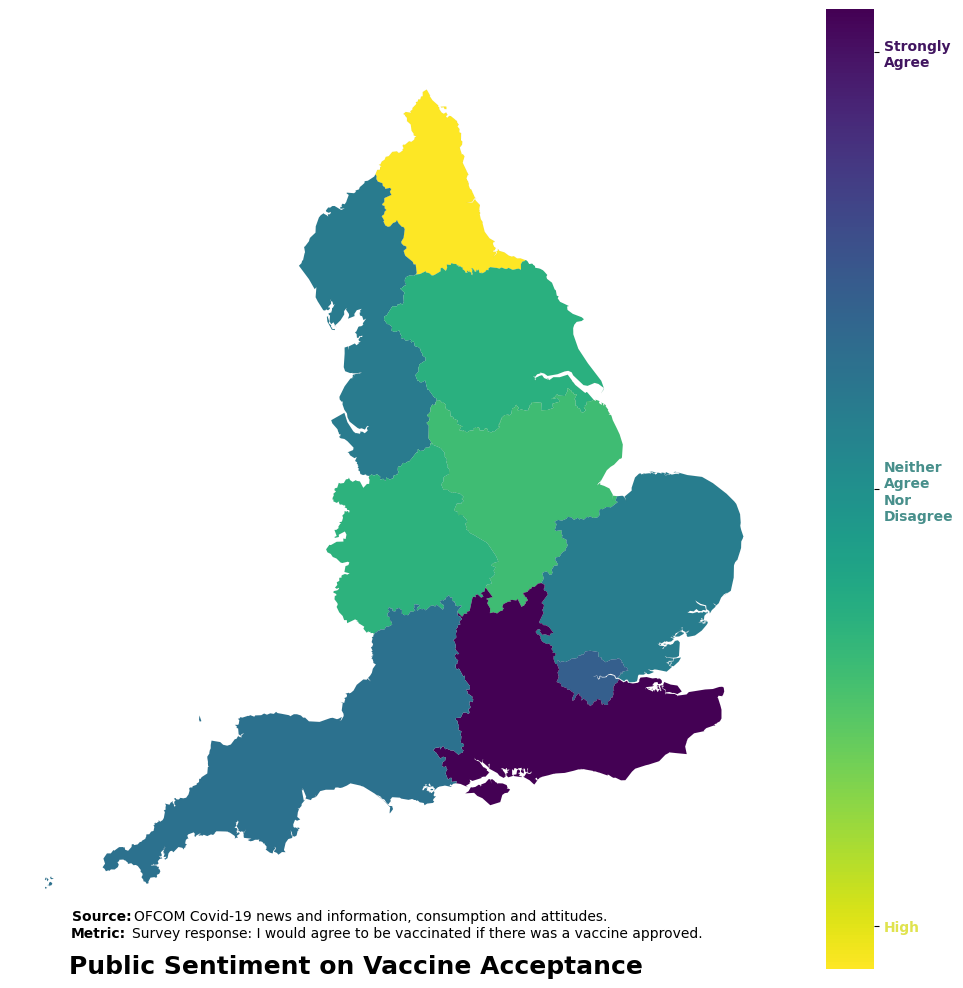

In [226]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

map_plot = merged_dataframe.plot(
    ax=ax, 
    column=merged_dataframe['vaccine_sentiment'], 
    cmap='viridis_r', 
    linewidth=0.01, 
    edgecolor='0', 
    legend=True
)

ax.text(0.45, -0.05, "Public Sentiment on Vaccine Acceptance", fontsize=18, color='black', fontweight='bold', ha='center', transform=ax.transAxes)
ax.text(0.12, 0.010, "Source:", fontsize=10, color='black', fontweight='bold', ha='center',  transform=ax.transAxes)
ax.text(0.47, 0.010, "OFCOM Covid-19 news and information, consumption and attitudes.", fontsize=10, color='black', ha='center',  transform=ax.transAxes)
ax.text(0.115, -0.01, "Metric:", fontsize=10, color='black', fontweight='bold', ha='center',  transform=ax.transAxes)
ax.text(0.53, -0.01, "Survey response: I would agree to be vaccinated if there was a vaccine approved.", fontsize=10, color='black', ha='center',  transform=ax.transAxes)

ax.set_xticks([])
ax.set_yticks([])

cbar = map_plot.get_figure().get_axes()[-1]

cbar.set_yticks(np.linspace(merged_dataframe['vaccine_sentiment'].min()+25, merged_dataframe['vaccine_sentiment'].max()-25, 3))
cbar.set_yticklabels(['High', 'Neither\nAgree\nNor\nDisagree', 'Strongly\nAgree'])
cbar.spines['outline'].set_visible(False) 

colours = ['#E0E34E', '#478F8B', '#411560' ]

for label, colour in zip(cbar.get_yticklabels(), colours):
    label.set_fontweight('bold')
    label.set_color(colour) 
    label.set_fontsize(10) 

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()

plt.show()

fig.savefig(r"../../8_final_visualisations/misinformation_ofcom/vaccination/willingness_for_vaccination.png", dpi=300)

plt.close('all')

### Uptake of vaccination by region

In [227]:
december_region_vaccination

,percentage_vaccine_uptake
area_name,
east_midlands,0.060550
east_of_england,0.054953
london,0.043354
north_east,0.098421
north_west,0.072159
south_east,0.071699
south_west,0.079419
west_midlands,0.072831
yorkshire_and_the_humber,0.065215


In [228]:
merged_dataframe = pd.merge(gdf, december_region_vaccination, left_index=True, right_index=True)

In [229]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

map_plot = merged_dataframe.plot(
    ax=ax, 
    column=merged_dataframe['percentage_vaccine_uptake'], 
    cmap='viridis_r', 
    linewidth=0.01, 
    edgecolor='0',
    legend=True)

ax.text(0.31, -0.05, "Vaccine uptake by region", fontsize=18, color='black', fontweight='bold', ha='center', transform=ax.transAxes)
ax.text(0.12, 0.010, "Source:", fontsize=10, color='black', fontweight='bold', ha='center',  transform=ax.transAxes)
ax.text(0.37, 0.010, "UKHSA COVID-19 vaccine monitoring reports.", fontsize=10, color='black', ha='center',  transform=ax.transAxes)
ax.text(0.12, -0.01, "Metric:", fontsize=10, color='black', fontweight='bold', ha='center',  transform=ax.transAxes)
ax.text(0.33, -0.01, "Percentage Vaccine Uptake by Region.", fontsize=10, color='black', ha='center',  transform=ax.transAxes)

ax.set_xticks([])
ax.set_yticks([])

cbar = map_plot.get_figure().get_axes()[-1]

cbar.set_yticks(np.linspace(merged_dataframe['percentage_vaccine_uptake'].min()+0.003, merged_dataframe['percentage_vaccine_uptake'].max()-0.003, 3))
cbar.set_yticklabels(['Low', 'Medium', 'High'])
cbar.spines['outline'].set_visible(False) 

colours = ['#E0E34E', '#478F8B', '#411560' ]

for label, colour in zip(cbar.get_yticklabels(), colours):
    label.set_fontweight('bold')
    label.set_color(colour) 
    label.set_fontsize(10) 

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()

fig.savefig(r"../../8_final_visualisations/misinformation_ofcom/vaccination/vaccine_uptake_by_region.png", dpi=300)

plt.close('all')

##. 13 Sources of misinformation

In [230]:
sources = ofcom_dataframes['source_of_claims_about_about_face_maskscoverings_offering_no_protection_or_being_harmful__as_true']

In [231]:
list_sources = [
    'source_of_claims_about_about_face_maskscoverings_offering_no_protection_or_being_harmful__as_true',
    'source_of_claims_that_the_coronavirus_vaccine_is_a_cover_for_a_plan_to_implant_trackable_microchips_in_people_reported_as_true',
    'source_of_claims_about_empty_hospitals_on_social_media_posts_prove_that_coronavirus_has_been_exaggerated_reported_as_true',
    'source_of_theory_linking_coronavirus_to_5g_technology_reported_as_true',
    'source_of_claims_stating_that_the_flu_alone_is_killing_more_people_than_coronavirus_as_true',
    'source_of_claims_about_about_injecting_disinfectant_as_true',
    'source_of_claims_about_the_potential_dangers_of_a_coronavirus_vaccine_reported_as_true'
]

In [232]:
ofcom_dataframes['source_of_claims_about_about_face_maskscoverings_offering_no_protection_or_being_harmful__as_true']

,start_date,end_date,question,response,total,male,female,16-24,18-24,25-34,...,yorkshire_&_humberside,west_midlands,east_midlands,wales,eastern,london,south_east,south_west,northern_ireland,net:_england
0,2020-10-09,2020-10-11,source_of_claims_about_about_face_masks/coveri...,Unweighted base,235.0,109.0,126.0,23,20,37,...,16.0,11.0,22.0,13,19,30.0,31.0,21.0,7.0,190.0
1,2020-10-09,2020-10-11,source_of_claims_about_about_face_masks/coveri...,Weighted base,241.0,114.0,127.0,26,22,38,...,15.0,12.0,19.0,14,21,32.0,36.0,18.0,7.0,197.0
2,2020-10-09,2020-10-11,source_of_claims_about_about_face_masks/coveri...,“Red-top tabloids” such as The Sun or Mirror (...,2.0,1.0,1.0,0,0,1,...,0.0,1.0,0.0,0,0,0.0,0.0,0.0,0.0,2.0
3,2020-10-09,2020-10-11,source_of_claims_about_about_face_masks/coveri...,Non-mainstream news sources such as Russia Tod...,2.0,2.0,1.0,1,1,1,...,0.0,0.0,1.0,0,1,1.0,0.0,0.0,0.0,2.0
4,2020-10-09,2020-10-11,source_of_claims_about_about_face_masks/coveri...,Direct from NHS website/ email/ text/ post,2.0,2.0,0.0,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2020-10-09,2020-10-11,source_of_claims_about_about_face_masks/coveri...,Websites/apps of online news organisations lik...,4.0,2.0,2.0,0,0,1,...,NaN,1.0,NaN,0,0,0.0,1.0,1.0,0.0,4.0
62,2020-10-09,2020-10-11,source_of_claims_about_about_face_masks/coveri...,Snapchat,4.0,0.0,4.0,4,4,0,...,0.0,0.0,0.0,0,0,2.0,1.0,0.0,0.0,4.0
63,2020-10-09,2020-10-11,source_of_claims_about_about_face_masks/coveri...,WhatsApp group(s),3.0,1.0,3.0,2,2,0,...,0.0,0.0,0.0,1,0,3.0,0.0,0.0,0.0,3.0
64,2020-10-09,2020-10-11,source_of_claims_about_about_face_masks/coveri...,“Mid-market tabloids” such as The Daily Mail o...,8.0,6.0,2.0,0,0,0,...,0.0,0.0,0.0,1,1,0.0,0.0,1.0,0.0,7.0


In [233]:
sources_dataframe = ofcom_dataframes[list_sources[0]]

for i, source in enumerate(list_sources[1:]):
    sources_dataframe = pd.concat([sources_dataframe, ofcom_dataframes[list_sources[i]]], axis=0)    

In [234]:
sources_dataframe = sources_dataframe[['response', 'total']]

In [235]:
sources_dataframe = sources_dataframe.groupby('response')['total'].sum()

In [236]:
sources_dataframe = sources_dataframe.reset_index()
sources_dataframe.index.name = 'response'

In [237]:
sources_dataframe = sources_dataframe[~sources_dataframe['response'].str.contains('NET:')]
sources_dataframe = sources_dataframe[~sources_dataframe['response'].str.contains('Unweighted base')]
sources_dataframe = sources_dataframe[~sources_dataframe['response'].str.contains('Weighted base')]

In [238]:
response_counts = dict(zip(sources_dataframe['response'], sources_dataframe['total']))

wordcloud = WordCloud(width=500, height=300, background_color='white', colormap='viridis_r').generate_from_frequencies(response_counts)

fig, ax = plt.subplots(1, 1, figsize=(30, 20))
ax.imshow(wordcloud, interpolation="bilinear")

ax.axis("off")

ax.text(0.2, -0.1, "Sources of misinformation", fontsize=50, color='black', fontweight='bold', ha='center', transform=ax.transAxes)
ax.text(0.005, -0.025, "Source:", fontsize=20, color='black', fontweight='bold', ha='center',  transform=ax.transAxes)
ax.text(0.24, -0.025, "OFCOM Covid-19 news and information, consumption and attitudes.", fontsize=20, color='black', ha='center',  transform=ax.transAxes)
ax.text(0.005, -0.05, "Metric:", fontsize=20, color='black', fontweight='bold', ha='center',  transform=ax.transAxes)
ax.text(0.18, -0.05, "Frequency of reported source for misinformation.", fontsize=20, color='black', ha='center',  transform=ax.transAxes)

plt.savefig(r"../../8_final_visualisations/misinformation_ofcom/sources_of_misinformation/sources_of_misinformation_word_cloud.png", dpi=300)

plt.close()